## Librerias

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import prince
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

# Metricas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sksurv.metrics import concordance_index_censored

# Modelos
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## Parametros

In [2]:
client_bq = bigquery.Client()

In [3]:
table = 'Diabetes_avicena_survival.diabetes_final'

variables_with_outliers = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal']

numeric_columns = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal']
categoric_columns = ['genero_paciente','raza_paciente','nivel_academico_paciente','ant_cardio','med_hipertension','ant_familiar_dm','hace_ejercicio']
target = 'diabetes'

dict_var_categoricas = {
    # Nivel Academico
    "Ninguno" : 'ninguno',

    "Básica secundaria" : 'educacion_basica', 
    "Básica primaria" : 'educacion_basica',

    "Normalista" : 'educacion_media',
    "Bachillerato técnico" : 'educacion_media',
    "Técnica profesional" : 'educacion_media',
    "Tecnológica" : 'educacion_media',
    "Media académica o clásica" : 'educacion_media',

    "Profesional" : 'educacion_superior',
    "Especialización" : 'educacion_superior',
    "Preescolar" : 'educacion_superior',
    "Doctorado" : 'educacion_superior',
    "Maestría" : 'educacion_superior',
        
    # Ejercicio
    'Nunca' : 'No',
    '20 minutos' : '20 min',
    '40 minutos' : 'Mas de 20 min',
    '60 minutos' : 'Mas de 20 min',

    # Dicotomicas
    "1" : 'Si',
    '0' : 'No'
    

}

## Funciones

In [51]:
def criterio_benzecri(mca, plot = True):
    # Calcular la inercia total
    total_inertia = sum(mca.eigenvalues_)

    # Calcular el umbral de Benzécri
    benzecri_threshold = total_inertia / mca.n_components


    # Identificar las dimensiones a retener
    dimensions_to_keep = []
    for i in range(mca.n_components):
        if mca.eigenvalues_[i] > benzecri_threshold:
            dimensions_to_keep.append(i)

    # Visualizar las dimensiones retenidas
    print("Dimensiones retenidas (criterio de Benzécri):", dimensions_to_keep)

    if plot:
        # Puedes graficar la inercia explicada por cada dimensión
        plt.plot(range(1, mca.n_components + 1), mca.eigenvalues_, marker='o')
        plt.xlabel("Dimensión")
        plt.ylabel("Inercia explicada")
        plt.title("Inercia explicada por dimensión")
        plt.show()

    dimensions_to_keep = [f'Component_mca_{i}' for i in dimensions_to_keep]

    return dimensions_to_keep

def MCA(data, n_comp, benzecri = True, plot = True):
    ## Creacion de ejes principales con MCA

    # Definicion del MCA
    mca = prince.MCA(n_components=n_comp)

    # Entrenamiento del MCA
    mca.fit(data)

    # Convertir los datos categoricos en los ejes
    components_mca=mca.fit_transform(data)

    # Nombrar los ejes
    name_of_columns_mca = [f'Component_mca_{i}' for i in range(len(components_mca.columns))]

    # Crear DataFrame con los ejes principales
    components_mca.columns = name_of_columns_mca

    if benzecri:
        # Criterio de benzecri para tomar ejes mas relevantes
        ejes_a_tomar_mca = criterio_benzecri(mca=mca, plot=plot)
        return components_mca, mca, ejes_a_tomar_mca
    else:
        return components_mca, mca, []

def ACP(data, n_comp, scale = True):

    if scale:
        # Crear el escalador
        scaler = MinMaxScaler()
        # Entrenar el escalador
        scaler.fit(data)
        # Re-escalar los datos
        df_escalado = pd.DataFrame(scaler.transform(data))
    else:
        df_escalado = df_numerico[::]

    # Crear PCA
    pca = PCA(n_components=n_comp)

    # Crear los ejes factoriales
    components=pca.fit_transform(df_escalado)

    # Nombrar los ejes
    number_of_axis = [f'Component_{i}' for i in range(n_comp)]

    # Crear DataFrame con los ejes principales
    components_df=pd.DataFrame(data=components,columns=number_of_axis)

    return components_df, pca

def crear_ejes(data, pca_columns, pca_n_comp, acm_columns, acm_n_comp, benzecri = True, plot = True, scale = True):
    components_df, pca = ACP(data[pca_columns], pca_n_comp, scale = scale)
    components_mca, mca, ejes_a_tomar_mca = MCA(data[acm_columns], acm_n_comp, benzecri = benzecri, plot = plot)

    if benzecri:
        full_data = components_df.reset_index().merge(components_mca[ejes_a_tomar_mca].reset_index(), on = 'index', how = 'left')
    else:
        full_data = components_df.reset_index().merge(components_mca.reset_index(), on = 'index', how = 'left')

    full_data.drop(columns = 'index', inplace = True)

    return full_data

## Carga de datos

In [5]:
data = client_bq.query(f'SELECT * FROM {table}').result().to_dataframe()
print(f'Se trajo {data.shape} datos de pacientes')
data.head()

Se trajo (9032, 21) datos de pacientes


,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
0,26151819,2022,8,2022-08-01,70,82.0,1.59,32.435425814,45.3,158.0,...,96.0,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,0,1
1,1007107070,2022,8,2022-08-01,19,56.0,1.61,21.604104780,56.0,99.0,...,75.0,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1,1
2,34341427,2024,1,2024-01-01,39,78.0,1.60,30.468750000,64.5,102.0,...,89.5,Femenino,Otros,Tecnológica,0,0,0,40 minutos,0,1
3,94426911,2024,1,2024-01-01,50,91.0,1.75,29.714285714,38.0,150.8,...,95.0,Masculino,Mestizo,Básica secundaria,0,0,0,Nunca,0,1
4,43524938,2024,1,2024-01-01,56,56.0,1.55,23.309053070,51.0,143.4,...,74.5,Femenino,Otros,Técnica profesional,0,0,0,20 minutos,0,1


## Proceso

In [6]:
# Dataframe con los datos numericos
df_numerico = data[numeric_columns]
df_numerico['IMC'] = np.round(df_numerico['IMC'].astype(float),2)

df_numerico.head()

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal
0,70,32.44,45.3,158.0,238.0,96.0
1,19,21.60,56.0,99.0,95.0,75.0
2,39,30.47,64.5,102.0,162.1,89.5
3,50,29.71,38.0,150.8,211.0,95.0
4,56,23.31,51.0,143.4,254.7,74.5


In [7]:
# Dataframe con los datos categoricos
df_categorico = data[categoric_columns].astype(str)

df_categorico.hace_ejercicio = df_categorico.hace_ejercicio.replace(dict_var_categoricas)
df_categorico.nivel_academico_paciente = df_categorico.nivel_academico_paciente.replace(dict_var_categoricas)
df_categorico.ant_cardio = df_categorico.ant_cardio.replace(dict_var_categoricas)
df_categorico.med_hipertension = df_categorico.med_hipertension.replace(dict_var_categoricas)

df_categorico = df_categorico.drop(columns = ['ant_familiar_dm', 'raza_paciente'])

df_categorico

,genero_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,hace_ejercicio
0,Femenino,educacion_media,Si,No,20 min
1,Femenino,educacion_basica,No,No,No
2,Femenino,educacion_media,No,No,Mas de 20 min
3,Masculino,educacion_basica,No,No,No
4,Femenino,educacion_media,No,No,20 min
...,...,...,...,...,...
9027,Femenino,educacion_basica,Si,Si,No
9028,Masculino,educacion_superior,Si,Si,No
9029,Femenino,educacion_media,Si,Si,20 min
9030,Femenino,educacion_basica,Si,Si,20 min


In [8]:
# Conteo de las categorias de cada variable, con el re agrupamiento
for variable in df_categorico.columns:
    print(variable)
    conteos = df_categorico[f'{variable}'].value_counts().reset_index()
    total = conteos['count'].sum()
    conteos['Porcentaje'] = (conteos['count'] / total)*100
    display(conteos)

genero_paciente


,genero_paciente,count,Porcentaje
0,Femenino,5526,61.182462
1,Masculino,3506,38.817538


nivel_academico_paciente


,nivel_academico_paciente,count,Porcentaje
0,educacion_basica,3784,41.895483
1,educacion_media,2166,23.981399
2,ninguno,1855,20.538087
3,educacion_superior,1227,13.585031


ant_cardio


,ant_cardio,count,Porcentaje
0,Si,4579,50.69752
1,No,4453,49.30248


med_hipertension


,med_hipertension,count,Porcentaje
0,Si,5172,57.263065
1,No,3860,42.736935


hace_ejercicio


,hace_ejercicio,count,Porcentaje
0,No,4687,51.893268
1,20 min,2276,25.199291
2,Mas de 20 min,2069,22.907440


In [9]:
df_categorico.head()

,genero_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,hace_ejercicio
0,Femenino,educacion_media,Si,No,20 min
1,Femenino,educacion_basica,No,No,No
2,Femenino,educacion_media,No,No,Mas de 20 min
3,Masculino,educacion_basica,No,No,No
4,Femenino,educacion_media,No,No,20 min


Dimensiones retenidas (criterio de Benzécri): [0, 1, 2, 3, 4, 5, 6]


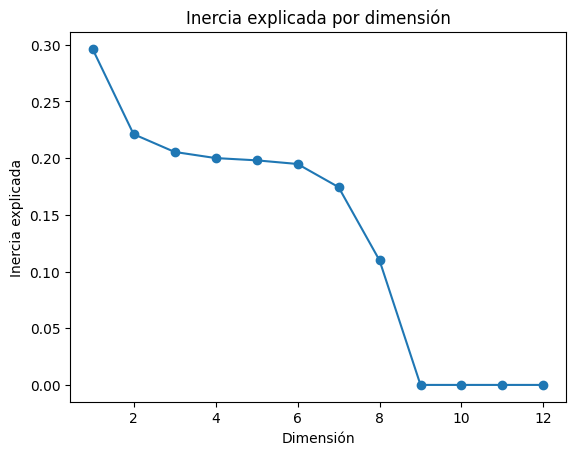

In [10]:
components_mca, mca, ejes_a_tomar_mca = MCA(df_categorico, n_comp= 12)

In [11]:
components_df, pca = ACP(data = df_numerico, n_comp= len(numeric_columns))

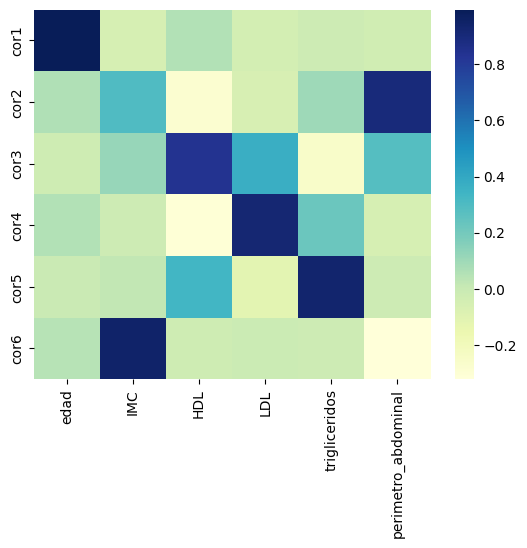

In [12]:
# Ver correlacion entre variables numericas y los ejes principales de PCA
ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=["cor"+str(x) for x in range(1,pca.n_components_ + 1)],
                 xticklabels=list(df_numerico))

### Entrenamiento con Ejes principales

In [112]:
data_to_train = components_df.reset_index().merge(components_mca[ejes_a_tomar_mca].reset_index(), on = 'index', how = 'left')
data_to_train.drop(columns = ['index'], inplace=True)

# data_to_train = components_mca[ejes_a_tomar_mca]

data_to_train

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_mca_0,Component_mca_1,Component_mca_2,Component_mca_3,Component_mca_4,Component_mca_5,Component_mca_6
0,0.126540,0.035677,0.007557,0.084509,0.022568,0.030112,0.051111,-0.270039,-0.415843,0.673971,0.745963,-0.191365,0.177635
1,-0.459476,-0.190124,-0.004979,-0.056730,-0.004701,-0.027625,0.603169,-0.585911,-0.127942,-0.110082,-0.509803,-0.033969,-0.250061
2,-0.228302,-0.063842,0.061864,-0.053513,0.037105,0.013260,0.770671,0.253331,-0.101167,0.864013,-0.213753,-0.251022,0.617652
3,-0.110425,0.018185,-0.025727,0.070788,0.000681,0.001919,0.540426,0.070086,0.011401,-0.172271,-0.418883,-0.111479,-0.857813
4,-0.027331,-0.151673,-0.029654,0.057068,0.045267,0.005735,0.662330,-0.342297,-0.405388,0.685375,0.726846,-0.313544,0.082154
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9027,0.251844,0.161126,0.023549,0.062553,0.000135,0.029670,-0.630397,-0.490926,-0.150448,-0.130348,-0.471203,0.169154,-0.042885
9028,-0.203245,0.058829,-0.043590,-0.016819,-0.017311,-0.018019,-0.413424,0.492577,0.277079,-0.288829,0.207979,1.187180,-0.299451
9029,0.155922,-0.026667,-0.143275,0.011336,0.039569,0.018792,-0.571236,-0.247312,-0.427893,0.665109,0.765446,-0.110421,0.289330
9030,0.055900,-0.191245,0.050092,-0.066929,0.014709,-0.006540,-0.612805,-0.362535,-0.780208,-0.292353,0.293413,-0.186402,0.125339


In [113]:
y = data[['diabetes','time_to_event']]
y['target'] = y.apply(lambda x: (bool(x.diabetes), x.time_to_event), axis = 1)
y = y['target']
y = np.array(y, dtype=[('event', np.bool_), ('time', np.int32)])

display(y[:5])

X = data_to_train #components_df

display(X.head(5))

random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print(f'Las dimensiones del entrenamiento son {X_train.shape} para X_train, {y_train.shape} para y_train')
print(f'Las dimensiones del entrenamiento son {X_test.shape} para X_test, {y_test.shape} para y_test')

rsf = RandomSurvivalForest(
    max_depth=100, min_samples_leaf=50, min_samples_split=30,
                     n_estimators=50, n_jobs=-1#, bootstrap = False
)

rsf.fit(X_train, y_train)
# rsf.set_fit_request(X_train, y_train, sample_weight=[2,1])


print('El modelo tiene un valor score de :',rsf.score(X_test, y_test))

surv = rsf.predict_survival_function(X_test)
tiempos_supervivencia = [int(y_test[i][1]) for i in range(len(y_test))]
eventos = [bool(y_test[i][0]) for i in range(len(y_test))]
tiempo_mediano = np.median(tiempos_supervivencia)
puntuaciones_riesgo = -np.log([f(tiempo_mediano) for f in surv])

c_index = concordance_index_censored(eventos, tiempos_supervivencia, puntuaciones_riesgo)

c_index[0]

array([(False, 1), ( True, 1), (False, 1), (False, 1), (False, 1)],
      dtype=[('event', '?'), ('time', '<i4')])

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_mca_0,Component_mca_1,Component_mca_2,Component_mca_3,Component_mca_4,Component_mca_5,Component_mca_6
0,0.126540,0.035677,0.007557,0.084509,0.022568,0.030112,0.051111,-0.270039,-0.415843,0.673971,0.745963,-0.191365,0.177635
1,-0.459476,-0.190124,-0.004979,-0.056730,-0.004701,-0.027625,0.603169,-0.585911,-0.127942,-0.110082,-0.509803,-0.033969,-0.250061
2,-0.228302,-0.063842,0.061864,-0.053513,0.037105,0.013260,0.770671,0.253331,-0.101167,0.864013,-0.213753,-0.251022,0.617652
3,-0.110425,0.018185,-0.025727,0.070788,0.000681,0.001919,0.540426,0.070086,0.011401,-0.172271,-0.418883,-0.111479,-0.857813
4,-0.027331,-0.151673,-0.029654,0.057068,0.045267,0.005735,0.662330,-0.342297,-0.405388,0.685375,0.726846,-0.313544,0.082154


Las dimensiones del entrenamiento son (7225, 13) para X_train, (7225,) para y_train
Las dimensiones del entrenamiento son (1807, 13) para X_test, (1807,) para y_test
El modelo tiene un valor score de : 0.5789472035878259


np.float64(0.5547804273070636)

In [114]:
estimator = GradientBoostingSurvivalAnalysis(loss="coxph")

estimator.fit(X_train, y_train)

estimator.score(X_test, y_test)

np.float64(0.5710800433445453)

In [115]:
y = data[['diabetes','time_to_event']]
y['target'] = y.apply(lambda x: (bool(x.diabetes), x.time_to_event), axis = 1)
y = y['target']
y = np.array(y, dtype=[('event', np.bool_), ('time', np.int32)])

display(y[:5])

X = data_to_train #components_df

display(X.head(5))

random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print(f'Las dimensiones del entrenamiento son {X_train.shape} para X_train, {y_train.shape} para y_train')
print(f'Las dimensiones del entrenamiento son {X_test.shape} para X_test, {y_test.shape} para y_test')

rsf = RandomSurvivalForest(
    max_depth=100, min_samples_leaf=50, min_samples_split=30,
                     n_estimators=50, n_jobs=-1#, bootstrap = False
)

rsf.fit(X_train, y_train)
# rsf.set_fit_request(X_train, y_train, sample_weight=[2,1])


print('El modelo tiene un valor score de :',rsf.score(X_test, y_test))

surv = rsf.predict_survival_function(X_test)
tiempos_supervivencia = [int(y_test[i][1]) for i in range(len(y_test))]
eventos = [bool(y_test[i][0]) for i in range(len(y_test))]
tiempo_mediano = np.median(tiempos_supervivencia)
puntuaciones_riesgo = -np.log([f(tiempo_mediano) for f in surv])

c_index = concordance_index_censored(eventos, tiempos_supervivencia, puntuaciones_riesgo)

c_index[0]

array([(False, 1), ( True, 1), (False, 1), (False, 1), (False, 1)],
      dtype=[('event', '?'), ('time', '<i4')])

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_mca_0,Component_mca_1,Component_mca_2,Component_mca_3,Component_mca_4,Component_mca_5,Component_mca_6
0,0.126540,0.035677,0.007557,0.084509,0.022568,0.030112,0.051111,-0.270039,-0.415843,0.673971,0.745963,-0.191365,0.177635
1,-0.459476,-0.190124,-0.004979,-0.056730,-0.004701,-0.027625,0.603169,-0.585911,-0.127942,-0.110082,-0.509803,-0.033969,-0.250061
2,-0.228302,-0.063842,0.061864,-0.053513,0.037105,0.013260,0.770671,0.253331,-0.101167,0.864013,-0.213753,-0.251022,0.617652
3,-0.110425,0.018185,-0.025727,0.070788,0.000681,0.001919,0.540426,0.070086,0.011401,-0.172271,-0.418883,-0.111479,-0.857813
4,-0.027331,-0.151673,-0.029654,0.057068,0.045267,0.005735,0.662330,-0.342297,-0.405388,0.685375,0.726846,-0.313544,0.082154


Las dimensiones del entrenamiento son (7225, 13) para X_train, (7225,) para y_train
Las dimensiones del entrenamiento son (1807, 13) para X_test, (1807,) para y_test
El modelo tiene un valor score de : 0.581800301908538


np.float64(0.5649291266575217)

In [116]:
estimator = GradientBoostingSurvivalAnalysis(loss="coxph")

estimator.fit(X_train, y_train)

estimator.score(X_test, y_test)

np.float64(0.5710800433445453)

In [ ]:
{'max_depth': 100,
'min_samples_leaf': 50, 
'min_samples_split': 30,
'n_estimators': 50}

{'max_depth': 100,
 'min_samples_leaf': 100,
 'min_samples_split': 30,
 'n_estimators': 20}

In [ ]:
# Refinamiento de hiper parametros

parameters = {'n_estimators':[50, 20],
              'max_depth' : [100, 200, 400],
              'min_samples_split':[30, 60],
              'min_samples_leaf':[50, 100]
              }

rsf_grid = RandomSurvivalForest()

clf = GridSearchCV(rsf_grid, parameters)

clf.fit(X, y)

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values('mean_test_score', ascending = False).head()

In [ ]:
clf.best_estimator_ 

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_ 

#### Training con oversampling y undersampling

In [117]:
dict_catergoricas = {
    'Femenino' : 0,
    'Masculino' : 1,
    "Mestizo" : 0,
    "Otros" : 1,
    "Afrocolombiano" : 2,
    "Raizales" : 3,
    "Indígena" : 4,
    "Palenquero" : 5,
    "Rom/Gitano" : 6,
    "Bachillerato técnico" : 0,
    "Básica secundaria" : 1,
    "Tecnológica" : 2,
    "Técnica profesional" : 3,
    "Profesional" : 4,
    "Ninguno" : 5,
    "Básica primaria" : 6,
    "Media académica o clásica" : 7,
    "Normalista" : 8,
    "Especialización" : 9,
    "Preescolar" : 10,
    "Doctorado" : 11,
    "Maestría" : 12,
    "20 minutos" : 0,
    "40 minutos" : 1,
    "Nunca" : 2,
    "60 minutos" : 3,
}

In [131]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [137]:
help(RandomOverSampler)

Help on class RandomOverSampler in module imblearn.over_sampling._random_over_sampler:

class RandomOverSampler(imblearn.over_sampling.base.BaseOverSampler)
 |  RandomOverSampler(*, sampling_strategy='auto', random_state=None, shrinkage=None)
 |  
 |  Class to perform random over-sampling.
 |  
 |  Object to over-sample the minority class(es) by picking samples at random
 |  with replacement. The bootstrap can be generated in a smoothed manner.
 |  
 |  Read more in the :ref:`User Guide <random_over_sampler>`.
 |  
 |  Parameters
 |  ----------
 |  sampling_strategy : float, str, dict or callable, default='auto'
 |      Sampling information to resample the data set.
 |  
 |      - When ``float``, it corresponds to the desired ratio of the number of
 |        samples in the minority class over the number of samples in the
 |        majority class after resampling. Therefore, the ratio is expressed as
 |        :math:`\alpha_{os} = N_{rm} / N_{M}` where :math:`N_{rm}` is the
 |        nu

In [141]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy = 'minority')
smote = SMOTE()

In [144]:
print(len(data.drop_duplicates()))

data_over_sampled.drop_duplicates()

9032


,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,time_to_event,diabetes
0,26151819,2022,8,2022-08-01,0.619048,82.0,1.59,0.150023,0.182544,0.246682,...,0.507692,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,1,0
1,1007107070,2022,8,2022-08-01,0.011905,56.0,1.61,0.062908,0.239489,0.154567,...,0.346154,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1,1
2,34341427,2024,1,2024-01-01,0.250000,78.0,1.60,0.134205,0.284726,0.159251,...,0.457692,Femenino,Otros,Tecnológica,0,0,0,40 minutos,1,0
3,94426911,2024,1,2024-01-01,0.380952,91.0,1.75,0.128137,0.143693,0.235441,...,0.500000,Masculino,Mestizo,Básica secundaria,0,0,0,Nunca,1,0
4,43524938,2024,1,2024-01-01,0.452381,56.0,1.55,0.076620,0.212879,0.223888,...,0.342308,Femenino,Otros,Técnica profesional,0,0,0,20 minutos,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9027,28833810,2022,1,2022-01-01,0.750000,79.6,1.48,0.181431,0.166578,0.221702,...,0.623077,Femenino,Otros,Básica primaria,1,1,0,Nunca,36,0
9028,72249308,2022,1,2022-01-01,0.285714,85.0,1.70,0.125704,0.133582,0.151756,...,0.546154,Masculino,Otros,Profesional,1,1,0,Nunca,36,0
9029,25654517,2022,1,2022-01-01,0.642857,58.1,1.48,0.102485,0.104311,0.124902,...,0.415385,Femenino,Otros,Tecnológica,1,1,0,20 minutos,36,0
9030,24166911,2022,1,2022-01-01,0.523810,52.0,1.57,0.058823,0.324641,0.142077,...,0.338462,Femenino,Otros,Básica secundaria,1,1,0,20 minutos,36,0


In [142]:
X = data.drop(columns = 'diabetes')
y = data['diabetes']

X_over, y_over = oversample.fit_resample(X, y)

y_over = pd.DataFrame(y_over)

data_over_sampled = X_over.reset_index().merge(y_over.reset_index(), on = 'index', how = 'left')

df_categorico_over_sampled = data_over_sampled[categoric_columns].astype(str)

df_categorico_over_sampled.hace_ejercicio = df_categorico_over_sampled.hace_ejercicio.replace(dict_var_categoricas)
df_categorico_over_sampled.nivel_academico_paciente = df_categorico_over_sampled.nivel_academico_paciente.replace(dict_var_categoricas)
df_categorico_over_sampled.ant_cardio = df_categorico_over_sampled.ant_cardio.replace(dict_var_categoricas)
df_categorico_over_sampled.med_hipertension = df_categorico_over_sampled.med_hipertension.replace(dict_var_categoricas)

df_categorico_over_sampled = df_categorico_over_sampled.drop(columns = ['ant_familiar_dm', 'raza_paciente'])

df_categorico_over_sampled

display(data_over_sampled.head())

# Crear el escalador
scaler = MinMaxScaler()
# Entrenar el escalador
scaler.fit(data_over_sampled[numeric_columns])
# Re-escalar los datos
df_escalado = pd.DataFrame(scaler.transform(data_over_sampled[numeric_columns]))

i = 0
for column in numeric_columns:
    data_over_sampled[column] = df_escalado.iloc[:,i].values
    i += 1

data_over_sampled.drop(columns = 'index', inplace = True)

display(data_over_sampled.head())

,index,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,time_to_event,diabetes
0,0,26151819,2022,8,2022-08-01,70,82.0,1.59,32.435425814,45.3,...,96.0,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,1,0
1,1,1007107070,2022,8,2022-08-01,19,56.0,1.61,21.604104780,56.0,...,75.0,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1,1
2,2,34341427,2024,1,2024-01-01,39,78.0,1.60,30.468750000,64.5,...,89.5,Femenino,Otros,Tecnológica,0,0,0,40 minutos,1,0
3,3,94426911,2024,1,2024-01-01,50,91.0,1.75,29.714285714,38.0,...,95.0,Masculino,Mestizo,Básica secundaria,0,0,0,Nunca,1,0
4,4,43524938,2024,1,2024-01-01,56,56.0,1.55,23.309053070,51.0,...,74.5,Femenino,Otros,Técnica profesional,0,0,0,20 minutos,1,0


,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,time_to_event,diabetes
0,26151819,2022,8,2022-08-01,0.619048,82.0,1.59,0.150023,0.182544,0.246682,...,0.507692,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,1,0
1,1007107070,2022,8,2022-08-01,0.011905,56.0,1.61,0.062908,0.239489,0.154567,...,0.346154,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1,1
2,34341427,2024,1,2024-01-01,0.250000,78.0,1.60,0.134205,0.284726,0.159251,...,0.457692,Femenino,Otros,Tecnológica,0,0,0,40 minutos,1,0
3,94426911,2024,1,2024-01-01,0.380952,91.0,1.75,0.128137,0.143693,0.235441,...,0.500000,Masculino,Mestizo,Básica secundaria,0,0,0,Nunca,1,0
4,43524938,2024,1,2024-01-01,0.452381,56.0,1.55,0.076620,0.212879,0.223888,...,0.342308,Femenino,Otros,Técnica profesional,0,0,0,20 minutos,1,0


Dimensiones retenidas (criterio de Benzécri): [0, 1, 2, 3, 4]


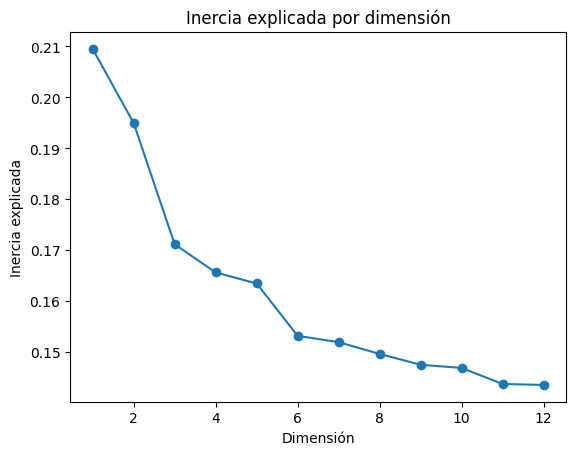

array([(False, 1), ( True, 1), (False, 1), (False, 1), (False, 1)],
      dtype=[('event', '?'), ('time', '<i4')])

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_mca_0,Component_mca_1,Component_mca_2,Component_mca_3,Component_mca_4
0,0.123629,0.028522,0.011112,0.087489,0.020016,0.029184,0.043665,0.213129,-0.483262,-1.420294,1.114253
1,-0.460192,-0.196611,-0.004042,-0.064147,-0.002313,-0.028419,0.472442,-0.149139,-0.015955,0.344332,0.055952
2,-0.230023,-0.067964,0.061495,-0.056521,0.039312,0.012410,0.614877,-0.237934,0.002390,0.119184,0.085545
3,-0.112850,0.009630,-0.023780,0.071629,-0.000758,0.000114,0.522413,-0.073390,-0.183142,-1.010988,0.416379
4,-0.028833,-0.159702,-0.024753,0.055093,0.042950,0.007165,0.559886,-0.125608,-0.236116,0.076648,0.289341


Las dimensiones del entrenamiento son (12032, 11) para X_train, (12032,) para y_train
Las dimensiones del entrenamiento son (3008, 11) para X_test, (3008,) para y_test
El modelo tiene un valor score de : 0.6993291005077031


np.float64(0.7447864798966058)

In [145]:
## Entrenamiento con Ejes Factoriales

data_to_train = crear_ejes(data_over_sampled, 
                           numeric_columns, 
                           6, 
                           categoric_columns, 
                           12, 
                           benzecri = True, 
                           plot = True, 
                           scale = True)


y = data_over_sampled[['diabetes','time_to_event']]
y['target'] = y.apply(lambda x: (bool(x.diabetes), x.time_to_event), axis = 1)
y = y['target']
y = np.array(y, dtype=[('event', np.bool_), ('time', np.int32)])

display(y[:5])

X = data_to_train

display(X.head(5))

random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print(f'Las dimensiones del entrenamiento son {X_train.shape} para X_train, {y_train.shape} para y_train')
print(f'Las dimensiones del entrenamiento son {X_test.shape} para X_test, {y_test.shape} para y_test')

rsf = RandomSurvivalForest(
    max_depth=100, min_samples_leaf=50, min_samples_split=30,
                     n_estimators=50, n_jobs=-1
)

rsf.fit(X_train, y_train)

print('El modelo tiene un valor score de :',rsf.score(X_test, y_test))

surv = rsf.predict_survival_function(X_test)
tiempos_supervivencia = [int(y_test[i][1]) for i in range(len(y_test))]
eventos = [bool(y_test[i][0]) for i in range(len(y_test))]
tiempo_mediano = np.median(tiempos_supervivencia)
puntuaciones_riesgo = -np.log([f(tiempo_mediano) for f in surv])

c_index = concordance_index_censored(eventos, tiempos_supervivencia, puntuaciones_riesgo)

c_index[0]

In [123]:
estimator = GradientBoostingSurvivalAnalysis(loss="coxph")

estimator.fit(X_train, y_train)

estimator.score(X_test, y_test)

np.float64(0.5931867819701109)

In [124]:
data_to_train = data_over_sampled[::]
data_to_train.drop(columns = ['ant_familiar_dm'], inplace=True)
data_to_train.columns = data_to_train.columns.astype(str)

data_to_train.genero_paciente = data_to_train.genero_paciente.replace(dict_catergoricas)
data_to_train.raza_paciente = data_to_train.raza_paciente.replace(dict_catergoricas)
data_to_train.nivel_academico_paciente = data_to_train.nivel_academico_paciente.replace(dict_catergoricas)
data_to_train.hace_ejercicio = data_to_train.hace_ejercicio.replace(dict_catergoricas)

y = data_to_train[['diabetes','time_to_event']]
y['target'] = y.apply(lambda x: (bool(x.diabetes), x.time_to_event), axis = 1)
y = y['target']
y = np.array(y, dtype=[('event', np.bool_), ('time', np.int32)])

display(y[:5])

X = data_to_train.iloc[:,5:].drop(columns = ['diabetes','time_to_event']) #components_df

display(X.head(5))

random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print(f'Las dimensiones del entrenamiento son {X_train.shape} para X_train, {y_train.shape} para y_train')
print(f'Las dimensiones del entrenamiento son {X_test.shape} para X_test, {y_test.shape} para y_test')

rsf = RandomSurvivalForest(
    max_depth=100, min_samples_leaf=50, min_samples_split=30,
                     n_estimators=50, n_jobs=-1
)

rsf.fit(X_train, y_train)

print('El modelo tiene un valor score de :',rsf.score(X_test, y_test))

surv = rsf.predict_survival_function(X_test)
tiempos_supervivencia = [int(y_test[i][1]) for i in range(len(y_test))]
eventos = [bool(y_test[i][0]) for i in range(len(y_test))]
tiempo_mediano = np.median(tiempos_supervivencia)
puntuaciones_riesgo = -np.log([f(tiempo_mediano) for f in surv])

c_index = concordance_index_censored(eventos, tiempos_supervivencia, puntuaciones_riesgo)

c_index[0]

array([(False, 1), ( True, 1), (False, 1), (False, 1), (False, 1)],
      dtype=[('event', '?'), ('time', '<i4')])

,peso,talla,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,hace_ejercicio
0,82.0,1.59,0.150023,0.182544,0.246682,0.111517,0.507692,0,0,0,1,0,0
1,56.0,1.61,0.062908,0.239489,0.154567,0.044151,0.346154,0,1,1,0,0,2
2,78.0,1.60,0.134205,0.284726,0.159251,0.075761,0.457692,0,1,2,0,0,1
3,91.0,1.75,0.128137,0.143693,0.235441,0.098798,0.500000,1,0,1,0,0,2
4,56.0,1.55,0.076620,0.212879,0.223888,0.119385,0.342308,0,1,3,0,0,0


Las dimensiones del entrenamiento son (12032, 13) para X_train, (12032,) para y_train
Las dimensiones del entrenamiento son (3008, 13) para X_test, (3008,) para y_test
El modelo tiene un valor score de : 0.6487205380677541


np.float64(0.714467609470977)

In [125]:
estimator = GradientBoostingSurvivalAnalysis(loss="coxph")

estimator.fit(X_train, y_train)

estimator.score(X_test, y_test)

np.float64(0.5831355225702362)

In [126]:
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

X_under_sampled, y_under_sampled = rus.fit_resample(data.drop(columns = 'diabetes'), data['diabetes'])

df_under_sampled = X_under_sampled.reset_index().merge(y_under_sampled.reset_index() , on = 'index', how = 'left')

df_under_sampled.drop(columns = 'index', inplace  = True)

df_under_sampled

,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,time_to_event,diabetes
0,48574170,2022,11,2022-11-01,43,66.000000,1.680,23.384353741,47.0,162.6,...,88.00,Femenino,Otros,Básica secundaria,0,0,0,20 minutos,22,0
1,30685593,2024,4,2024-04-01,42,63.000000,1.580,25.236340330,36.6,141.8,...,91.00,Femenino,Otros,Tecnológica,0,1,0,Nunca,6,0
2,51572420,2024,4,2024-04-01,64,80.150000,1.680,28.397817460,44.0,184.0,...,99.00,Femenino,Otros,Técnica profesional,1,1,0,Nunca,6,0
3,4652975,2023,10,2023-10-01,54,74.000000,1.700,25.605536332,35.0,175.0,...,92.00,Masculino,Afrocolombiano,Básica secundaria,1,1,0,Nunca,14,0
4,43421958,2024,6,2024-06-01,47,65.600000,1.665,23.663302943,102.0,89.9,...,79.00,Femenino,Otros,Básica secundaria,0,0,0,60 minutos,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,34536262,2024,7,2024-07-01,77,53.000000,1.324,30.234298701,51.4,48.0,...,84.00,Femenino,Otros,Básica secundaria,0,1,0,20 minutos,30,1
3020,1035444289,2024,7,2024-07-01,72,77.333333,1.640,28.752726552,58.0,211.0,...,80.85,Femenino,Otros,Básica secundaria,0,1,0,60 minutos,30,1
3021,22704096,2024,7,2024-07-01,53,74.000000,1.540,31.202563670,53.0,60.0,...,96.00,Femenino,Otros,Bachillerato técnico,0,1,0,20 minutos,30,1
3022,31214325,2022,3,2022-03-01,72,81.100000,1.510,35.568615412,69.6,98.0,...,120.00,Femenino,Otros,Ninguno,1,1,0,Nunca,32,1


Dimensiones retenidas (criterio de Benzécri): [0, 1, 2, 3, 4]


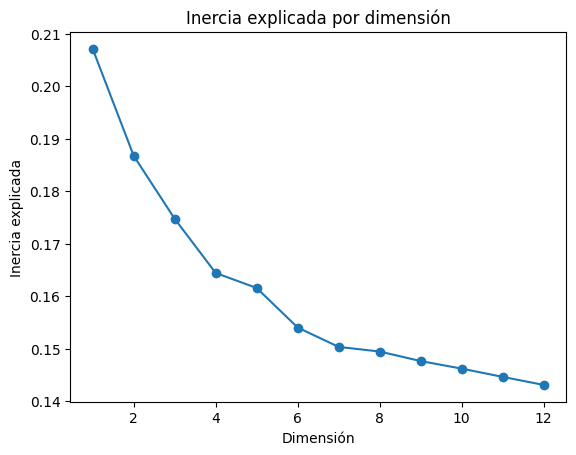

array([(False, 22), (False,  6), (False,  6), (False, 14), (False,  6)],
      dtype=[('event', '?'), ('time', '<i4')])

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_mca_0,Component_mca_1,Component_mca_2,Component_mca_3,Component_mca_4
0,-0.208967,-0.097426,0.090944,-0.025523,-0.023968,-0.035404,0.512363,-0.103839,-0.027511,0.137770,0.145612
1,-0.220532,-0.038038,0.042649,-0.072259,-0.029783,-0.027995,0.063951,-0.073480,-0.115925,0.317060,0.094525
2,0.048295,0.001552,0.199219,-0.043605,0.024001,-0.013206,-0.507523,0.051502,-0.108417,0.143785,0.136488
3,-0.076323,-0.046462,0.142685,-0.085177,-0.062965,-0.021954,-0.423304,0.599794,0.063956,1.313690,0.010348
4,-0.125360,-0.222185,-0.097273,0.282457,0.056981,-0.008525,0.666751,-0.242036,-0.012813,-0.276679,-0.116068


Las dimensiones del entrenamiento son (2419, 11) para X_train, (2419,) para y_train
Las dimensiones del entrenamiento son (605, 11) para X_test, (605,) para y_test
El modelo tiene un valor score de : 0.5149611784666899


np.float64(0.5168151735451757)

In [127]:
data_to_train = crear_ejes(df_under_sampled, 
                           numeric_columns, 
                           6, 
                           categoric_columns, 
                           12, 
                           benzecri = True, 
                           plot = True, 
                           scale = True)

# data_to_train = df_under_sampled #components_df.reset_index().merge(components_mca[ejes_a_tomar_mca].reset_index(), on = 'index', how = 'left')
# data_to_train.drop(columns = ['index'], inplace=True)

y = df_under_sampled[['diabetes','time_to_event']]
y['target'] = y.apply(lambda x: (bool(x.diabetes), x.time_to_event), axis = 1)
y = y['target']
y = np.array(y, dtype=[('event', np.bool_), ('time', np.int32)])

display(y[:5])

X = data_to_train#.sample(len(data[data.diabetes == 1])) #components_df

display(X.head(5))

random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print(f'Las dimensiones del entrenamiento son {X_train.shape} para X_train, {y_train.shape} para y_train')
print(f'Las dimensiones del entrenamiento son {X_test.shape} para X_test, {y_test.shape} para y_test')

rsf = RandomSurvivalForest(
    max_depth=100, min_samples_leaf=50, min_samples_split=30,
                     n_estimators=50, n_jobs=-1#, bootstrap = False
)

rsf.fit(X_train, y_train)
# rsf.set_fit_request(X_train, y_train, sample_weight=[2,1])


print('El modelo tiene un valor score de :',rsf.score(X_test, y_test))

surv = rsf.predict_survival_function(X_test)
tiempos_supervivencia = [int(y_test[i][1]) for i in range(len(y_test))]
eventos = [bool(y_test[i][0]) for i in range(len(y_test))]
tiempo_mediano = np.median(tiempos_supervivencia)
puntuaciones_riesgo = -np.log([f(tiempo_mediano) for f in surv])

c_index = concordance_index_censored(eventos, tiempos_supervivencia, puntuaciones_riesgo)

c_index[0]

In [128]:
estimator = GradientBoostingSurvivalAnalysis(loss="coxph")

estimator.fit(X_train, y_train)

estimator.score(X_test, y_test)

np.float64(0.517545535242761)

In [129]:
data_to_train = df_under_sampled[::]
data_to_train.drop(columns = ['ant_familiar_dm'], inplace=True)
data_to_train.columns = data_to_train.columns.astype(str)

data_to_train.genero_paciente = data_to_train.genero_paciente.replace(dict_catergoricas)
data_to_train.raza_paciente = data_to_train.raza_paciente.replace(dict_catergoricas)
data_to_train.nivel_academico_paciente = data_to_train.nivel_academico_paciente.replace(dict_catergoricas)
data_to_train.hace_ejercicio = data_to_train.hace_ejercicio.replace(dict_catergoricas)

y = data_to_train[['diabetes','time_to_event']]
y['target'] = y.apply(lambda x: (bool(x.diabetes), x.time_to_event), axis = 1)
y = y['target']
y = np.array(y, dtype=[('event', np.bool_), ('time', np.int32)])

display(y[:5])

X = data_to_train.iloc[:,5:].drop(columns = ['diabetes','time_to_event']) #components_df

display(X.head(5))

random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print(f'Las dimensiones del entrenamiento son {X_train.shape} para X_train, {y_train.shape} para y_train')
print(f'Las dimensiones del entrenamiento son {X_test.shape} para X_test, {y_test.shape} para y_test')

rsf = RandomSurvivalForest(
    max_depth=100, min_samples_leaf=50, min_samples_split=30,
                     n_estimators=50, n_jobs=-1
)

rsf.fit(X_train, y_train)

print('El modelo tiene un valor score de :',rsf.score(X_test, y_test))

surv = rsf.predict_survival_function(X_test)
tiempos_supervivencia = [int(y_test[i][1]) for i in range(len(y_test))]
eventos = [bool(y_test[i][0]) for i in range(len(y_test))]
tiempo_mediano = np.median(tiempos_supervivencia)
puntuaciones_riesgo = -np.log([f(tiempo_mediano) for f in surv])

c_index = concordance_index_censored(eventos, tiempos_supervivencia, puntuaciones_riesgo)

c_index[0]

array([(False, 22), (False,  6), (False,  6), (False, 14), (False,  6)],
      dtype=[('event', '?'), ('time', '<i4')])

,peso,talla,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,hace_ejercicio
0,66.00,1.680,23.384353741,47.0,162.6,117.0,88.0,0,1,1,0,0,0
1,63.00,1.580,25.236340330,36.6,141.8,138.0,91.0,0,1,2,0,1,2
2,80.15,1.680,28.397817460,44.0,184.0,241.0,99.0,0,1,3,1,1,2
3,74.00,1.700,25.605536332,35.0,175.0,88.0,92.0,1,2,1,1,1,2
4,65.60,1.665,23.663302943,102.0,89.9,65.4,79.0,0,1,1,0,0,3


Las dimensiones del entrenamiento son (2419, 13) para X_train, (2419,) para y_train
Las dimensiones del entrenamiento son (605, 13) para X_test, (605,) para y_test
El modelo tiene un valor score de : 0.5258491859276155


np.float64(0.5529849320763621)

In [130]:
estimator = GradientBoostingSurvivalAnalysis(loss="coxph")

estimator.fit(X_train, y_train)

estimator.score(X_test, y_test)

np.float64(0.5252255694012158)

#### GradientBoostingSurvivalAnalysis

In [126]:
estimator = GradientBoostingSurvivalAnalysis(loss="coxph")

estimator.fit(X_train, y_train)

estimator.score(X_test, y_test)

np.float64(0.5710800433445453)

In [117]:
# estimator = GradientBoostingSurvivalAnalysis(loss="coxph")

{'criterion': 'friedman_mse',
 'learning_rate': 2,
 'loss': 'ipcwls',
 'n_estimators': 50}

estimator = GradientBoostingSurvivalAnalysis(criterion='squared_error', learning_rate = .5, loss = 'coxph', n_estimators= 50)

estimator.fit(X_train, y_train)

estimator.score(X_test, y_test)

np.float64(0.5837905807041609)

In [97]:
# Refinamiento de hiper parametros

parameters = {'loss' : ['coxph', 'squared', 'ipcwls'],
              'learning_rate' : [0.1,0.5,1,2],
              'n_estimators':[50,100,200],
              'criterion':['friedman_mse', 'squared_error']
              }

gbsa_grid = GradientBoostingSurvivalAnalysis()

clf = GridSearchCV(gbsa_grid, parameters)

clf.fit(X, y)

GridSearchCV(estimator=GradientBoostingSurvivalAnalysis(),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.1, 0.5, 1, 2],
                         'loss': ['coxph', 'squared', 'ipcwls'],
                         'n_estimators': [50, 100, 200]})

In [115]:
pd.DataFrame(clf.cv_results_).sort_values('mean_test_score', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
69,1.108949,0.035362,0.014070,0.002518,squared_error,2.0,ipcwls,50,"{'criterion': 'squared_error', 'learning_rate'...",0.480031,0.501115,0.445868,0.484073,0.704564,0.523130,0.092472,1
33,1.195583,0.041465,0.015508,0.003054,friedman_mse,2.0,ipcwls,50,"{'criterion': 'friedman_mse', 'learning_rate':...",0.480031,0.501115,0.445868,0.484073,0.704564,0.523130,0.092472,1
34,2.306769,0.064607,0.014283,0.002091,friedman_mse,2.0,ipcwls,100,"{'criterion': 'friedman_mse', 'learning_rate':...",0.480031,0.498316,0.445868,0.484073,0.706098,0.522877,0.093215,3
35,4.671957,0.103766,0.013952,0.001261,friedman_mse,2.0,ipcwls,200,"{'criterion': 'friedman_mse', 'learning_rate':...",0.480031,0.498316,0.445868,0.484073,0.706098,0.522877,0.093215,3
71,4.550123,0.053284,0.011675,0.006034,squared_error,2.0,ipcwls,200,"{'criterion': 'squared_error', 'learning_rate'...",0.480031,0.498316,0.445868,0.484073,0.706098,0.522877,0.093215,3


In [99]:
clf.best_estimator_ 

GradientBoostingSurvivalAnalysis(learning_rate=2, loss='ipcwls',
                                 n_estimators=50)

In [100]:
clf.best_score_

np.float64(0.5231302454857631)

In [102]:
clf.best_params_ 

{'criterion': 'friedman_mse',
 'learning_rate': 2,
 'loss': 'ipcwls',
 'n_estimators': 50}

In [119]:
surv = estimator.predict_survival_function(X_test)
tiempos_supervivencia = [int(y_test[i][1]) for i in range(len(y_test))]
eventos = [bool(y_test[i][0]) for i in range(len(y_test))]
tiempo_mediano = np.median(tiempos_supervivencia)
puntuaciones_riesgo = -np.log([f(tiempo_mediano) for f in surv])

c_index = concordance_index_censored(eventos, tiempos_supervivencia, puntuaciones_riesgo)

c_index

(np.float64(0.5871886176722977),
 np.int64(187031),
 np.int64(131352),
 np.int64(919),
 np.int64(15121))

In [121]:
# for i, s in enumerate(surv):
#     plt.step(rsf.event_times_, 1 - s, where="post")
# plt.ylabel("Hospital readmission probability")
# plt.xlabel("Time")
# plt.grid(True)
# plt.show()

### Entrenamiento sin Ejes principales

In [43]:
dict_catergoricas = {
    'Femenino' : 0,
    'Masculino' : 1,
    "Mestizo" : 0,
    "Otros" : 1,
    "Afrocolombiano" : 2,
    "Raizales" : 3,
    "Indígena" : 4,
    "Palenquero" : 5,
    "Rom/Gitano" : 6,
    "Bachillerato técnico" : 0,
    "Básica secundaria" : 1,
    "Tecnológica" : 2,
    "Técnica profesional" : 3,
    "Profesional" : 4,
    "Ninguno" : 5,
    "Básica primaria" : 6,
    "Media académica o clásica" : 7,
    "Normalista" : 8,
    "Especialización" : 9,
    "Preescolar" : 10,
    "Doctorado" : 11,
    "Maestría" : 12,
    "20 minutos" : 0,
    "Nunca" : 1,
    "40 minutos" : 2,
    "60 minutos" : 3,
}

In [46]:
data_to_train = df_escalado.reset_index().merge(data[categoric_columns].reset_index(), on = 'index', how = 'left')
# data_to_train = df_escalado.reset_index().merge(df_categorico.reset_index(), on = 'index', how = 'left')
data_to_train.drop(columns = ['index','ant_familiar_dm'], inplace=True)
# data_to_train.drop(columns = ['index'], inplace=True)
data_to_train.columns = data_to_train.columns.astype(str)

data_to_train.genero_paciente = data_to_train.genero_paciente.replace(dict_catergoricas)
data_to_train.raza_paciente = data_to_train.raza_paciente.replace(dict_catergoricas)
data_to_train.nivel_academico_paciente = data_to_train.nivel_academico_paciente.replace(dict_catergoricas)
data_to_train.hace_ejercicio = data_to_train.hace_ejercicio.replace(dict_catergoricas)

data_to_train

,0,1,2,3,4,5,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,hace_ejercicio
0,0.619048,0.150072,0.182544,0.246682,0.111517,0.507692,0,0,0,1,0,0
1,0.011905,0.062892,0.239489,0.154567,0.044151,0.346154,0,1,1,0,0,1
2,0.250000,0.134229,0.284726,0.159251,0.075761,0.457692,0,1,2,0,0,2
3,0.380952,0.128116,0.143693,0.235441,0.098798,0.500000,1,0,1,0,0,1
4,0.452381,0.076645,0.212879,0.223888,0.119385,0.342308,0,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9027,0.750000,0.181438,0.166578,0.221702,0.092674,0.623077,0,1,6,1,1,1
9028,0.285714,0.125704,0.133582,0.151756,0.072888,0.546154,1,1,4,1,1,1
9029,0.642857,0.102461,0.104311,0.124902,0.142609,0.415385,0,1,2,1,1,0
9030,0.523810,0.058871,0.324641,0.142077,0.037556,0.338462,0,1,1,1,1,0


In [47]:
y = data[['diabetes','time_to_event']]
y['target'] = y.apply(lambda x: (bool(x.diabetes), x.time_to_event), axis = 1)
y = y['target']
y = np.array(y, dtype=[('event', np.bool_), ('time', np.int32)])

display(y[:5])

X = data_to_train

display(X.head(5))

random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

print(f'Las dimensiones del entrenamiento son {X_train.shape} para X_train, {y_train.shape} para y_train')
print(f'Las dimensiones del entrenamiento son {X_test.shape} para X_test, {y_test.shape} para y_test')

# rsf = RandomSurvivalForest(
#     n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state
# )

rsf = RandomSurvivalForest(
    max_depth=100, min_samples_leaf=50, min_samples_split=30,
                     n_estimators=50, n_jobs=-1
)

rsf.fit(X_train, y_train)

print('El modelo tiene un valor score de :',rsf.score(X_test, y_test))

surv = rsf.predict_survival_function(X_test)
tiempos_supervivencia = [int(y_test[i][1]) for i in range(len(y_test))]
eventos = [bool(y_test[i][0]) for i in range(len(y_test))]
tiempo_mediano = np.median(tiempos_supervivencia)
puntuaciones_riesgo = -np.log([f(tiempo_mediano) for f in surv])

c_index = concordance_index_censored(eventos, tiempos_supervivencia, puntuaciones_riesgo)

c_index[0]

array([(False, 1), ( True, 1), (False, 1), (False, 1), (False, 1)],
      dtype=[('event', '?'), ('time', '<i4')])

,0,1,2,3,4,5,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,hace_ejercicio
0,0.619048,0.150072,0.182544,0.246682,0.111517,0.507692,0,0,0,1,0,0
1,0.011905,0.062892,0.239489,0.154567,0.044151,0.346154,0,1,1,0,0,1
2,0.250000,0.134229,0.284726,0.159251,0.075761,0.457692,0,1,2,0,0,2
3,0.380952,0.128116,0.143693,0.235441,0.098798,0.500000,1,0,1,0,0,1
4,0.452381,0.076645,0.212879,0.223888,0.119385,0.342308,0,1,3,0,0,0


Las dimensiones del entrenamiento son (6774, 12) para X_train, (6774,) para y_train
Las dimensiones del entrenamiento son (2258, 12) para X_test, (2258,) para y_test
El modelo tiene un valor score de : 0.585477414508412


np.float64(0.5709414654196676)

In [ ]:
estimator = GradientBoostingSurvivalAnalysis(loss="coxph")

estimator.fit(X_train, y_train)

estimator.score(X_test, y_test)

In [200]:
rsf.score(X_test, y_test)

np.float64(0.5406830417976873)

In [124]:
surv = rsf.predict_survival_function(X_test)
tiempos_supervivencia = [int(y_test[i][1]) for i in range(len(y_test))]
eventos = [bool(y_test[i][0]) for i in range(len(y_test))]
tiempo_mediano = np.median(tiempos_supervivencia)
puntuaciones_riesgo = -np.log([f(tiempo_mediano) for f in surv])

c_index = concordance_index_censored(eventos, tiempos_supervivencia, puntuaciones_riesgo)

c_index

(np.float64(0.5694552714328813),
 np.int64(281242),
 np.int64(212637),
 np.int64(0),
 np.int64(24070))

In [122]:
y_pred_test = rsf.predict(X_test).astype(int)
y_pred_test

array([ 4, 16,  2, ..., 18,  7,  3])